In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

MEMORY = 4*1024

gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.set_logical_device_configuration(gpus[0],
                                              [tf.config.LogicalDeviceConfiguration(memory_limit=MEMORY)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
except RuntimeError as e:        
    # Memory growth must be set before GPUs have been initialized
    print(e) 
    
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
from turing.utils import *
from turing.tf_utils import *
import turing.pinns as tu
from turing.loss_functions import *

2023-03-23 17:20:02.684775: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-23 17:20:02.911068: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-23 17:20:03.618800: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /end/home/rh2310/lib:/end/soft/Linux_2.6_64/lib::/end/home/rh2310/.conda/envs/tensorflo

1 Physical GPUs, 1 Logical GPUs


2023-03-23 17:20:09.874495: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-23 17:20:10.358326: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4096 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:65:00.0, compute capability: 8.6


In [2]:
from local_utils import *

In [3]:
import pandas as pd
df_params = pd.read_pickle("../../bacterialcolony_dataset3/turing_df_circuit2_variant1_1000000parametersets.pkl")

In [4]:
df_params.head()

,DA,DB,bA,bB,bC,bD,bE,bF,VA,VB,...,nfe,nee,neb,nce,ss_n,ss_list,ss_class,system_class,maxeig,complex_dispersion
404,1.0,0.001,0.01,0.01,0.01,0.01,0.01,0.01,615.268976,73.210081,...,4.0,4.0,4.0,1.0,2.0,"[0.1997, 0.039, 10.9848, 104.771, 244.7529, 3....",stable spiral,turing I oscillatory,0.004898+0.036487j,True
2726,1.0,0.001,0.01,0.01,0.01,0.01,0.01,0.01,228.017071,94.502643,...,4.0,4.0,4.0,1.0,2.0,"[83.3645, 0.276, 12736.8586, 66.0485, 579.5646...",stable spiral,turing I oscillatory,0.000114+0.002647j,True
3508,1.0,0.001,0.01,0.01,0.01,0.01,0.01,0.01,23.538028,320.885489,...,4.0,4.0,4.0,1.0,3.0,"[6.9465, 0.1825, 57.5198, 3.3825, 131.0374, 1....",stable spiral,turing I oscillatory,0.001639+0.132134j,True
7516,1.0,0.001,0.01,0.01,0.01,0.01,0.01,0.01,16.205693,83.166774,...,4.0,4.0,4.0,1.0,1.0,"[1.7525, 0.2247, 908.552, 10.6864, 225.1614, 2...",stable spiral,turing I oscillatory,0.000652+0.003066j,True
7883,1.0,0.001,0.01,0.01,0.01,0.01,0.01,0.01,85.164519,738.495294,...,4.0,4.0,4.0,1.0,2.0,"[2.8165, 0.0136, 82.5102, 2.7508, 154.2711, 3....",stable spiral,turing I oscillatory,0.001346+0.016362j,True


In [5]:
import pickle

with open('../../bacterialcolony_dataset3/2Dfinal_circuit2_variant1_bc1.7_ca_ID546780_L8_J160_T125_N2500.pkl', 'rb') as f:
    ds_1 = pickle.load(f)
    
with open('../../bacterialcolony_dataset/caMask_seed1_pdivision0.5_L10_J150_T120_N1200.pkl', 'rb') as f:
    mask = pickle.load(f)


In [6]:
ID = 546780
L = 8
data = np.array(ds_1)[:, :, :, np.newaxis]
nodes_n = data.shape[0]
node_names = ["A", "B", "C", "D", "E", "F"]
x_size = data.shape[1]
y_size = data.shape[2]
T=1
dxdy = L**2/(x_size*y_size)
N = x_size*y_size    
t_star = np.arange(T, T+1)

##########################
# select a subset of data
#t_star = t_star[-4:]
#T = len(t_star)
#data = data[:, :, :, -4::]


x_slice = slice(65, 100, 1)
y_slice = slice(65, 100, 1)

x_range = L * np.linspace(0, 1, x_size)[x_slice]
y_range = L * np.linspace(0, 1, y_size)[y_slice]

block_x = x_range.shape[0]
block_y = y_range.shape[0]

x = tf.constant(x_range, dtype=tf.float32)
y = tf.constant(y_range, dtype=tf.float32)


# The order of the Y and X must be reversed,
# since the chnages the value finds the derivatives
#Y, X = tf.meshgrid(x, y)

X, Y = tf.meshgrid(x, y)
ts = tf.constant(t_star, dtype=tf.float32)
T = ts[tf.newaxis, tf.newaxis, :] * tf.ones(X.shape)[:, :, tf.newaxis]
def H_cube(X, Y, T):
    return tf.concat(
            [
                tf.concat(
                    [
                        X[tf.newaxis, :, :, tf.newaxis],
                        Y[tf.newaxis, :, :, tf.newaxis],
                        T[:, :, i : i + 1][tf.newaxis, :, :, :],
                    ],
                    axis=3,
                )
                for i in range(T.shape[-1])
            ],
            axis=0,
        )
H = H_cube(X, Y, T)

#      Periodic boundary condition
X_R = tf.concat([X[:, 1:] ,  X[:, 0:1]], axis=1)
X_L = tf.concat([X[:, -1:], X[:, :-1]], axis=1)
Y_D = tf.concat([Y[1:, :] ,  Y[0:1, :]], axis=0)
Y_U = tf.concat([ Y[1:, :], Y[0:1, :]], axis=0)


    
H_R = H_cube(X_R, Y, T)
H_L = H_cube(X_L, Y, T)
H_D = H_cube(X, Y_D, T)
H_U = H_cube(X, Y_U, T)


maxs = np.array([np.max(data[i, :, :, :]) for i in range(data.shape[0])])
mins = np.array([np.min(data[i, :, :, :]) for i in range(data.shape[0])])

In [7]:
df_params.loc[ID,:]

DA                                                                  1.0
DB                                                                0.001
bA                                                                 0.01
bB                                                                 0.01
bC                                                                 0.01
bD                                                                 0.01
bE                                                                 0.01
bF                                                                 0.01
VA                                                            46.733347
VB                                                           134.697819
VC                                                            53.677758
VD                                                            44.231763
VE                                                            943.26562
VF                                                           605

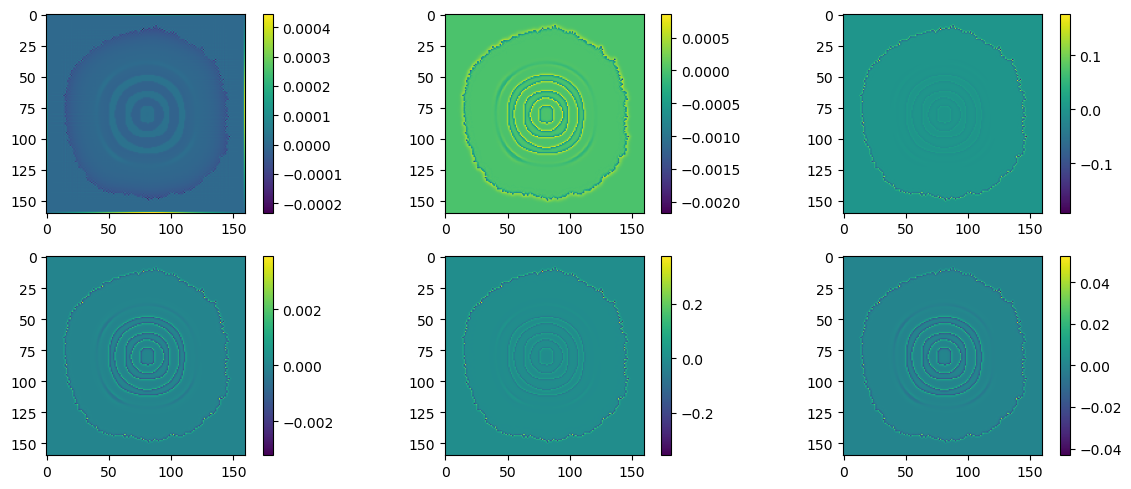

In [8]:
c_xx =  np.array([[ dxdy  * second_order_derivatives((x_size,y_size), data[c, ..., t])[0] 
                        for t in range(data.shape[3])]
                        for c in range(data.shape[0])
                       ])
c_xx = np.einsum("ctij -> cijt", c_xx)
c_yy = np.array([[ dxdy * second_order_derivatives((x_size,y_size), data[c, ..., t])[1] 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
c_yy = np.einsum("ctij -> cijt", c_yy)

# c_t = np.array([[(data_time[c, ..., t+1] -  data_time[c, ..., t])/(t_star_time[t+1] - t_star_time[t])
#                     for t in range(data.shape[3])]
#                     for c in range(data.shape[0])
#                    ])
# c_t = np.einsum("ctij -> cijt", c_t)

plt.figure(figsize=(12, 5))
for i in range(6):
    plt.subplot(2,3, i+1)
    plt.imshow((c_xx[i,:, : , -1] + c_yy[i,:, : , -1]))
    plt.colorbar()
plt.tight_layout();plt.show()


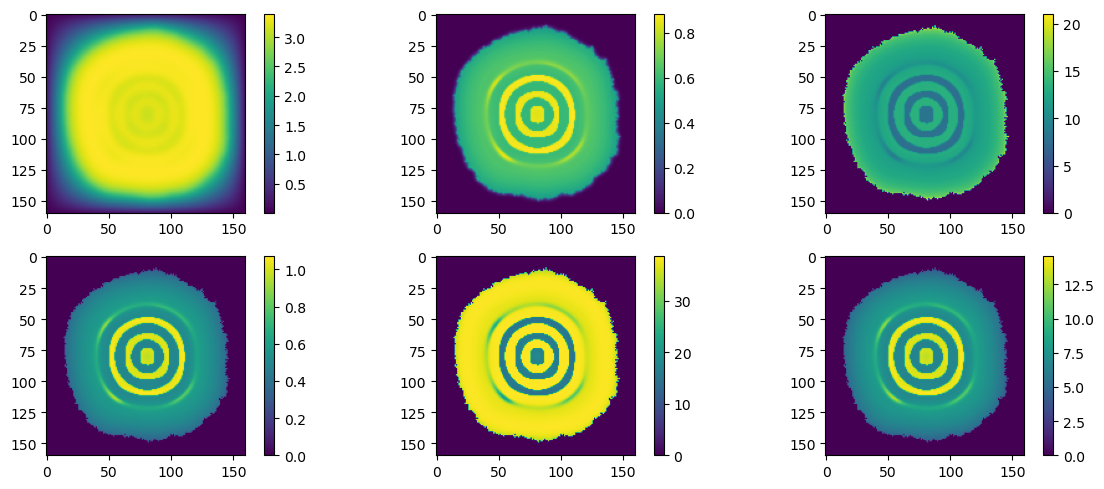

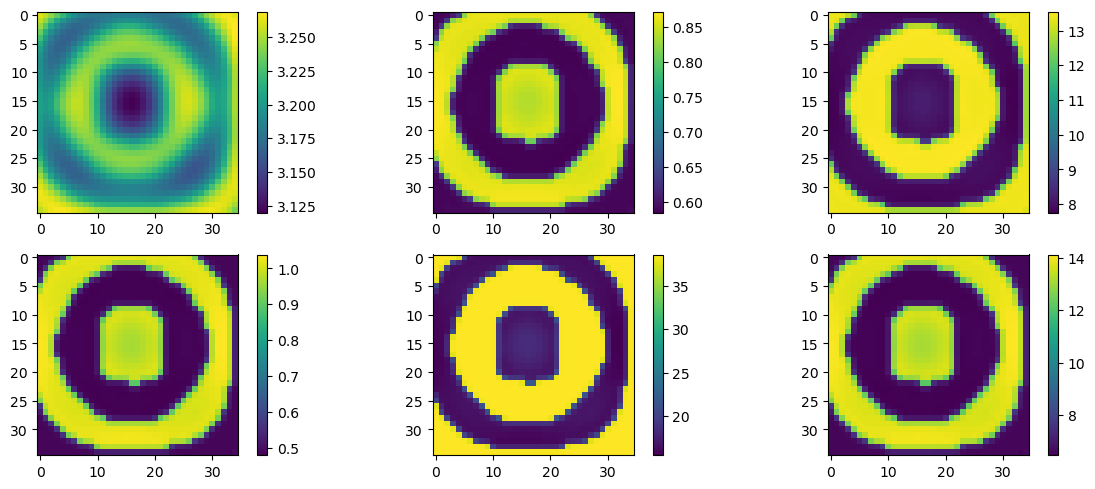

In [9]:
A = data[0, :, :, -1]
B = data[1, :, :, -1]
C = data[2, :, :, -1]
D = data[3, :, :, -1]
E = data[4, :, :, -1]
F = data[5, :, :, -1]

def activate(x, km, n=2):
    act = 1 / (1 + (km / (x + 1e-20)) ** (n))
    return act

def inhibit(x, km, n=2):
    inh = 1 / (1 + (x / (km + 1e-20)) ** (n))
    return inh

params = df_params.loc[ID, :]
DA = params.DA    
DB = params.DB
bA = params.bA
bB = params.bB
bC = params.bC
bD = params.bD
bE = params.bE
bF = params.bF
VA = params.VA
VB = params.VB
VC = params.VC
VD = params.VD
VE = params.VE
VF = params.VF
Kab = params.Kab
Kbd = params.Kbd
Kce = params.Kce
Kda = params.Kda
Keb = params.Keb
Kee = params.Kee
Kfe = params.Kfe
muASV = params.muASV
muLVA = params.muLVA
nab = params.nab
nbd = params.nbd
nce = params.nce
nda = params.nda
nfe = params.nfe
neb = params.neb
nee = params.nee

A_rhs = DA * (c_xx[0, :, :, 0] + c_yy[0, :, :, 0])# - u_t
B_rhs = DB * (c_xx[1, :, :, 0] + c_yy[1, :, :, 0])# - v_t

f_A =  - bA - VA * inhibit(D, Kda, nda) + muASV * A - A_rhs
f_B =  - bB - VB * activate(A, Kab, nab) * inhibit(E, Keb, neb) + muASV * B - B_rhs
f_C =  - bC - VC * inhibit(D, Kda, nda) + muLVA * C
f_D =  - bD - VD * activate(B, Kbd, nbd) + muLVA * D
f_E =  - bE - VE * inhibit(C, Kce, nce) * inhibit(F, Kfe, nfe) * activate(E, Kee, nee) + muLVA * E
f_F =  - bF - VF * activate(B, Kbd, nbd) + muLVA * F

c_t = np.stack([f_A, f_B, f_C, f_D, f_E, f_F])[:,:,:, np.newaxis]

plt.figure(figsize=(12, 5))
for i in range(6):
    plt.subplot(2,3, i+1)
    plt.imshow(data[i, :, :, -1])
    plt.colorbar()
plt.tight_layout();plt.show()
plt.figure(figsize=(12, 5))
for i in range(6):
    plt.subplot(2,3, i+1)
    plt.imshow(data[i, x_slice, y_slice, -1])
    plt.colorbar()
plt.tight_layout();plt.show()

In [10]:
c = data[:, x_slice, y_slice, :].copy()
def gen_series():    
    
    for i in range(H.shape[0]):        
        yield H[i, ...], np.einsum( "cxy -> xyc", c[..., i]) 
        
ds = tf.data.Dataset.from_generator(gen_series,
                                    output_types=(tf.float32, tf.float32), 
                                    output_shapes=((H.shape[1],H.shape[2], H.shape[3]),
                                                   (c.shape[1],c.shape[2], c.shape[0])))

In [11]:
dxdy

0.0025

In [12]:
len(list(ds.as_numpy_iterator()))

1

In [13]:
def clip_by_value_zero_lb(z):
        return tf.clip_by_value(z, 0, 1e10,)
    
class tf_param:
    def __init__(self, name, value=None, is_constant=True):
        self.name = name
        self.value = df_params.loc[ID,:][name]
        if value is None:
            self.value = df_params.loc[ID,:][name]
        else:
            self.value = value
        self.is_constant = is_constant    
    

def create_pinn(layers=[3, 128, 128, 6],
                learning_rate=1e-2,
                w1=1, w2=1, w3=1, w4=1, w5=100, w6=100,w7=1,w8=1,
                DA_val=tf_param("DA"), DB_val=tf_param("DB"),
                bA_val=tf_param("bA"),bB_val=tf_param("bB"),bC_val=tf_param("bC"),
                bD_val=tf_param("bD"),bE_val=tf_param("bE"),bF_val=tf_param("bF"),
                VA_val=tf_param("VA"),VB_val=tf_param("VB"),VC_val=tf_param("VC"),
                VD_val=tf_param("VD"),VE_val=tf_param("VE"),VF_val=tf_param("VF"),
                Kab_val=tf_param("Kab"),Kbd_val=tf_param("Kbd"),Kce_val=tf_param("Kce"),
                Kda_val=tf_param("Kda"),Keb_val=tf_param("Keb"),Kee_val=tf_param("Kee"),
                Kfe_val=tf_param("Kfe"),muASV_val=tf_param("muASV"),muLVA_val=tf_param("muLVA"),
                nab_val=tf_param("nab"),nbd_val=tf_param("nbd"),nce_val=tf_param("nce"),
                nda_val=tf_param("nda"),nfe_val=tf_param("nfe"),neb_val=tf_param("neb"),
                nee_val=tf_param("nee")): 
    # SInce there is just one time step, the lower bound is zero and the upper bound is one
    lb = tf.constant([x_range[0], y_range[0], 0], dtype=tf.float32)
    ub =  tf.constant([x_range[-1], y_range[-1], t_star[0]], dtype=tf.float32)
    pinn = tu.NN_Scaled(layers, lb, ub, tf.float32)
    #optimizer=keras.optimizers.Adam(learning_rate=1e-2)   
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate)
    
    def create_tf_var(param, no_clip=False):
        print(f"{param.name}: {param.value}")
        if no_clip:
            return tf.Variable(param.value,
                               dtype=pinn.dtype,
                               name=param.name)
        else:
            return tf.Variable(param.value,
                               dtype=pinn.dtype,
                               name=param.name,
                               constraint=clip_by_value_zero_lb)
    
    DA = create_tf_var(DA_val)    
    DB = create_tf_var(DB_val)
    bA = create_tf_var(bA_val)#
    bB = create_tf_var(bB_val)#
    bC = create_tf_var(bC_val)#
    bD = create_tf_var(bD_val)#
    bE = create_tf_var(bE_val)#
    bF = create_tf_var(bF_val)#
    VA = create_tf_var(VA_val)
    VB = create_tf_var(VB_val)
    VC = create_tf_var(VC_val)
    VD = create_tf_var(VD_val)
    VE = create_tf_var(VE_val)
    VF = create_tf_var(VF_val)
    Kab = create_tf_var(Kab_val)
    Kbd = create_tf_var(Kbd_val)
    Kce = create_tf_var(Kce_val)
    Kda = create_tf_var(Kda_val)
    Keb = create_tf_var(Keb_val)
    Kee = create_tf_var(Kee_val)
    Kfe = create_tf_var(Kfe_val)
    muASV = create_tf_var(muASV_val)
    muLVA = create_tf_var(muLVA_val)
    nab = create_tf_var(nab_val)
    nbd = create_tf_var(nbd_val)
    nce = create_tf_var(nce_val)
    nda = create_tf_var(nda_val)
    nfe = create_tf_var(nfe_val)
    neb = create_tf_var(neb_val)
    nee = create_tf_var(nee_val)
                    
    w1 = tf.Variable(w1,dtype=pinn.dtype,name="w1")
    w2 = tf.Variable(w2,dtype=pinn.dtype,name="w2")
    w3 = tf.Variable(w3,dtype=pinn.dtype,name="w3")
    w4 = tf.Variable(w4,dtype=pinn.dtype,name="w4")
    w5 = tf.Variable(w5,dtype=pinn.dtype,name="w5")
    w6 = tf.Variable(w6,dtype=pinn.dtype,name="w6")
    w7 = tf.Variable(w7,dtype=pinn.dtype,name="w7")
    w8 = tf.Variable(w8,dtype=pinn.dtype,name="w8")
                        
    def as_tuple(val, param):
        if val.is_constant:
            return ()
        else:
            return (param,)
    
    
    params_trainable =(
                      as_tuple(DA_val, DA)
                    + as_tuple(DB_val, DB)
                    + as_tuple(bA_val, bA)
                    + as_tuple(bB_val, bB)
                    + as_tuple(bC_val, bC)
                    + as_tuple(bD_val, bD)
                    + as_tuple(bE_val, bE)
                    + as_tuple(bF_val, bF)
                    + as_tuple(VA_val, VA)
                    + as_tuple(VB_val, VB)
                    + as_tuple(VC_val, VC)
                    + as_tuple(VD_val, VD)
                    + as_tuple(VE_val, VE)
                    + as_tuple(VF_val, VF)
                    + as_tuple(Kab_val, Kab)
                    + as_tuple(Kbd_val, Kbd)
                    + as_tuple(Kce_val, Kce)
                    + as_tuple(Kda_val, Kda)
                    + as_tuple(Keb_val, Keb)
                    + as_tuple(Kee_val, Kee)
                    + as_tuple(Kfe_val, Kfe)
                    + as_tuple(muASV_val, muASV)
                    + as_tuple(muLVA_val, muLVA)
                    + as_tuple(nab_val, nab)
                    + as_tuple(nbd_val, nbd)
                    + as_tuple(nce_val, nce)
                    + as_tuple(nda_val, nda)
                    + as_tuple(nfe_val, nfe)
                    + as_tuple(neb_val, neb)
                    + as_tuple(nee_val, nee)
                   )

    @tf.function
    def train_step_inverse(elements):
        def flatten(arr):
            return tf.reshape(arr, (arr.shape[0]*arr.shape[1]*arr.shape[2], arr.shape[3]))
        
        # Using VALID padding removes the boundaries
        act_A_laplacian = pinn.derivative_fields(elements[1][..., 0:1], padding="VALID")  
        act_A_laplacian = flatten(act_A_laplacian)
        act_B_laplacian = pinn.derivative_fields(elements[1][..., 1:2], padding="VALID") 
        act_B_laplacian = flatten(act_B_laplacian)

        act_A_rhs = tf.squeeze(DA*act_A_laplacian/(dxdy))
        act_B_rhs = tf.squeeze(DB*act_B_laplacian/(dxdy))
        
        with tf.GradientTape(persistent=True) as tape: 
            H = elements[0]
            # remove the boundaries
            H = H[:, 1:-1, 1:-1, :]
            H = flatten(H)
            tape.watch(H)
            trainables = pinn.trainable_variables + params_trainable

            outputs = pinn.net(H)
            Ag = tf.squeeze(outputs[:, 0])
            Bg = tf.squeeze(outputs[:, 1])

            grad_A = tape.gradient(Ag, H)
            A_x = grad_A[:, 0]
            A_y = grad_A[:, 1]

            grad_B = tape.gradient(Bg, H)
            B_x = grad_B[:, 0]
            B_y = grad_B[:, 1]


            grad_A_x = tape.gradient(A_x, H)
            A_xx = grad_A_x[:, 0]
            grad_A_y = tape.gradient(A_y, H)
            A_yy = grad_A_y[:, 1]
            grad_B_x = tape.gradient(B_x, H)
            B_xx = grad_B_x[:, 0]
            grad_B_y = tape.gradient(B_y, H)
            B_yy = grad_B_y[:, 1]

            H2 = elements[1]
            # remove the boundaries
            H2 = H2[:, 1:-1, 1:-1, :]
            H2 = flatten(H2)
            
            A = tf.squeeze(H2[:, 0])
            B = tf.squeeze(H2[:, 1])
            C = tf.squeeze(H2[:, 2])
            D = tf.squeeze(H2[:, 3])
            E = tf.squeeze(H2[:, 4])
            F = tf.squeeze(H2[:, 5])                  

            def activate(x, km, n=2):
                act = 1 / (1 + (km / (x + 1e-20)) ** (n))
                return act

            def inhibit(x, km, n=2):
                inh = 1 / (1 + (x / (km + 1e-20)) ** (n))
                return inh

            A_rhs = DA * (A_xx + A_yy)# - u_t
            B_rhs = DB * (B_xx + B_yy)# - v_t

            f_A =  -bA -VA * inhibit(D, Kda, nda) + muASV * A - A_rhs
            f_B =  -bB -VB * activate(A, Kab, nab) * inhibit(E, Keb, neb) + muASV * B - B_rhs
            f_C =  -bC -VC * inhibit(D, Kda, nda) + muLVA * C
            f_D =  -bD -VD * activate(B, Kbd, nbd) + muLVA * D
            f_E =  -bE -VE * inhibit(C, Kce, nce) * inhibit(F, Kfe, nfe) * activate(E, Kee, nee) + muLVA * E
            f_F =  -bF -VF * activate(B, Kbd, nbd) + muLVA * F

            l2_res_A = tf.reduce_sum(f_A**2)
            l2_res_B = tf.reduce_sum(f_B**2)
            l2_res_C = tf.reduce_sum(f_C**2)
            l2_res_D = tf.reduce_sum(f_D**2)
            l2_res_E = tf.reduce_sum(f_E**2)
            l2_res_F = tf.reduce_sum(f_F**2)

            l2_res_A_rhs = tf.reduce_sum((A_rhs-act_A_rhs)**2)
            l2_res_B_rhs = tf.reduce_sum((B_rhs-act_B_rhs)**2)


            l2 = (w1*l2_res_A + w2*l2_res_B + w3*l2_res_C + w4*l2_res_D + 
                  w5*l2_res_E + w6*l2_res_F +  
                  w7*l2_res_A_rhs + w8*l2_res_B_rhs)

        grads = tape.gradient(l2, trainables)
        optimizer.apply_gradients(zip(grads, trainables))
        return (l2_res_A, l2_res_B, l2_res_C, l2_res_D, l2_res_E, l2_res_F,  
                l2_res_A_rhs, l2_res_B_rhs)
    
    names = ['l2_res_A', 'l2_res_B', 'l2_res_C', 'l2_res_D', 'l2_res_E', 'l2_res_F',  
            'l2_res_A_rhs', 'l2_res_B_rhs']

    def print_callback(printer, losses, epoch):

        printer(f"at epoch {epoch:d}, total loss: {np.sum(losses)}")
        printer(", ".join([f"{n}: {v:.8f}" for n,v in zip(names, losses)]))         
        printer(", ".join([f"{par.name}: {par.numpy()}" for par in params_trainable]))
    
    return (pinn, optimizer, train_step_inverse,params_trainable, names, print_callback,
            w1, w2, w3, w4, w5, w6, w7, w8)

In [14]:
(pinn1, optimizer1, train_step_inverse1,params_trainable1,names, print_callback1,
w1, w2, w3, w4, w5, w6, w7, w8) = create_pinn(learning_rate=1e-2,
bA_val=tf_param("bA", 1, False),bB_val=tf_param("bB", 1, False),bC_val=tf_param("bC", 1, False),
bD_val=tf_param("bD", 1, False),bE_val=tf_param("bE", 1, False),bF_val=tf_param("bF", 1, False),
VA_val=tf_param("VA", 1, False),VB_val=tf_param("VB", 1, False),VC_val=tf_param("VC", 1, False),
VD_val=tf_param("VD", 1, False),VE_val=tf_param("VE", 1, False),VF_val=tf_param("VF", 1, False),
w1=1, w2=1, w3=1000, w4=1000, w5=1000, w6=1000, w7=1, w8=1
)

(bA, bB, bC, bD, bE, bF, VA, VB, VC, VD, VE, VF) = params_trainable1

DA: 1.0
DB: 0.001
bA: 1
bB: 1
bC: 1
bD: 1
bE: 1
bF: 1
VA: 1
VB: 1
VC: 1
VD: 1
VE: 1
VF: 1
Kab: 112.03598370729861
Kbd: 4.693803436565611
Kce: 0.9930030959145896
Kda: 0.2699281477606056
Keb: 45.269302324109745
Kee: 0.563496304565512
Kfe: 10.08286680374087
muASV: 4.247713917996289
muLVA: 1.4288264760159275
nab: 1.0
nbd: 2.0
nce: 1.0
nda: 1.0
nfe: 4.0
neb: 4.0
nee: 4.0


In [15]:
epochs=150000+1
params_est = np.zeros((epochs, 12))

def epoch_callback1(epoch, loss_samples, index):
    params_est[epoch, : ] = (bA.numpy(), bB.numpy(), bC.numpy(), 
                             bD.numpy(), bE.numpy(), bF.numpy(),
                             VA.numpy(), VB.numpy(), VC.numpy(),
                             VD.numpy(), VE.numpy(), VF.numpy()
                            )

In [16]:
losses1 = tu.train(epochs=epochs,
                  batch_size=1225,
                  dataset = ds ,
                  train_step = train_step_inverse1,
                  train_step_returns_num = 8,
                  print_interval=500,
                  loss_sample_interval = 1,
                  stop_threshold=1e-5,
                  print_callback = print_callback1,
                  epoch_callback=epoch_callback1,
                  stop_condition=None)


Start of epoch 0
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-03-23 17:20:39.355737: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-23 17:20:40.523057: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-23 17:20:41.333837: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fa044004910 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-23 17:20:41.333893: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA A40, Compute Capability 8.6
2023-03-23 17:20:41.344443: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-23 17:20:41.694410: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


at epoch 0, total loss: 2427985.2481429577
l2_res_A: 165667.09375000, l2_res_B: 5068.84863281, l2_res_C: 217221.17187500, l2_res_D: 135.48362732, l2_res_E: 1796993.75000000, l2_res_F: 231876.92187500, l2_res_A_rhs: 11018.34472656, l2_res_B_rhs: 3.63365626
bA:0: 1.010000228881836, bB:0: 1.010000228881836, bC:0: 1.010000228881836, bD:0: 1.010000228881836, bE:0: 1.010000228881836, bF:0: 1.010000228881836, VA:0: 1.010000228881836, VB:0: 1.010000228881836, VC:0: 1.010000228881836, VD:0: 1.010000228881836, VE:0: 1.010000228881836, VF:0: 1.010000228881836
Time taken: 12.03s

Start of epoch 500
at epoch 500, total loss: 1632299.6268424988
l2_res_A: 13153.48437500, l2_res_B: 183.24728394, l2_res_C: 81242.28125000, l2_res_D: 103.22902679, l2_res_E: 1407817.37500000, l2_res_F: 115166.07812500, l2_res_A_rhs: 14577.99121094, l2_res_B_rhs: 55.94057083
bA:0: 5.135757923126221, bB:0: 2.8719096183776855, bC:0: 5.443409442901611, bD:0: 0.9483700394630432, bE:0: 5.8540239334106445, bF:0: 5.56848669052124


Start of epoch 7000
at epoch 7000, total loss: 247855.57831326034
l2_res_A: 501.36703491, l2_res_B: 51.26074219, l2_res_C: 2802.19506836, l2_res_D: 0.01513043, l2_res_E: 222169.57812500, l2_res_F: 21803.28906250, l2_res_A_rhs: 475.85299683, l2_res_B_rhs: 52.02015305
bA:0: 4.982147216796875, bB:0: 2.3502702713012695, bC:0: 6.502522945404053, bD:0: 0.021256795153021812, bE:0: 36.67938995361328, bF:0: 13.658180236816406, VA:0: 29.00494384765625, VB:0: 33.169281005859375, VC:0: 30.51587677001953, VD:0: 43.778961181640625, VE:0: 52.00387954711914, VF:0: 46.72285079956055
Time taken: 16.68s

Start of epoch 7500
at epoch 7500, total loss: 244597.56443544966
l2_res_A: 314.20233154, l2_res_B: 47.24474335, l2_res_C: 2100.62524414, l2_res_D: 0.00167605, l2_res_E: 220252.71875000, l2_res_F: 21435.66601562, l2_res_A_rhs: 399.48321533, l2_res_B_rhs: 47.62245941
bA:0: 4.168543815612793, bB:0: 2.2494444847106934, bC:0: 5.627557754516602, bD:0: 0.013612049631774426, bE:0: 36.54216003417969, bF:0: 13.5


Start of epoch 14000
at epoch 14000, total loss: 207269.34854369937
l2_res_A: 14.42278481, l2_res_B: 8.50696754, l2_res_C: 0.01103359, l2_res_D: 0.00009442, l2_res_E: 190425.79687500, l2_res_F: 16797.83007812, l2_res_A_rhs: 13.98295784, l2_res_B_rhs: 8.79775238
bA:0: 0.0672842338681221, bB:0: 0.9512771964073181, bC:0: 0.008344470523297787, bD:0: 0.009945642203092575, bE:0: 33.90260314941406, bF:0: 11.981584548950195, VA:0: 46.53557586669922, VB:0: 93.8775634765625, VC:0: 53.67670822143555, VD:0: 44.241798400878906, VE:0: 118.14898681640625, VF:0: 114.99878692626953
Time taken: 16.68s

Start of epoch 14500
at epoch 14500, total loss: 204658.121100055
l2_res_A: 14.00472927, l2_res_B: 6.97129250, l2_res_C: 0.01103226, l2_res_D: 0.00011582, l2_res_E: 188151.65625000, l2_res_F: 16463.54492188, l2_res_A_rhs: 14.79017925, l2_res_B_rhs: 7.14257908
bA:0: 0.03853819519281387, bB:0: 0.8580507636070251, bC:0: 0.008257806301116943, bD:0: 0.009831173345446587, bE:0: 33.69859313964844, bF:0: 11.8617


Start of epoch 21000
at epoch 21000, total loss: 172310.04087877486
l2_res_A: 10.77365017, l2_res_B: 0.39134955, l2_res_C: 0.01103193, l2_res_D: 0.00009441, l2_res_E: 159858.98437500, l2_res_F: 12429.05175781, l2_res_A_rhs: 10.43312073, l2_res_B_rhs: 0.39549917
bA:0: 0.026644201949238777, bB:0: 0.03140832483768463, bC:0: 0.008193207904696465, bD:0: 0.009945466183125973, bE:0: 31.058147430419922, bF:0: 10.307415008544922, VA:0: 46.68110656738281, VB:0: 133.77244567871094, VC:0: 53.677268981933594, VD:0: 44.241798400878906, VE:0: 187.29611206054688, VF:0: 183.53213500976562
Time taken: 16.68s

Start of epoch 21500
at epoch 21500, total loss: 169944.23330626002
l2_res_A: 10.54195023, l2_res_B: 0.36333340, l2_res_C: 0.01115147, l2_res_D: 0.00009441, l2_res_E: 157779.12500000, l2_res_F: 12142.85058594, l2_res_A_rhs: 10.97195148, l2_res_B_rhs: 0.36923933
bA:0: 0.02623460441827774, bB:0: 0.022747637704014778, bC:0: 0.008605210110545158, bD:0: 0.009947449900209904, bE:0: 30.855344772338867, b


Start of epoch 28000
at epoch 28000, total loss: 140820.29397655942
l2_res_A: 43.00272369, l2_res_B: 1.26205111, l2_res_C: 0.01110270, l2_res_D: 0.00009441, l2_res_E: 131998.21875000, l2_res_F: 8730.08398438, l2_res_A_rhs: 46.41225433, l2_res_B_rhs: 1.30301595
bA:0: 0.20163215696811676, bB:0: 0.042941853404045105, bC:0: 0.008284577168524265, bD:0: 0.009947494603693485, bE:0: 28.22018814086914, bF:0: 8.639999389648438, VA:0: 46.05484390258789, VB:0: 133.32376098632812, VC:0: 53.677364349365234, VD:0: 44.24180221557617, VE:0: 256.3558044433594, VF:0: 251.80059814453125
Time taken: 16.55s

Start of epoch 28500
at epoch 28500, total loss: 138619.59433009414
l2_res_A: 7.43619680, l2_res_B: 0.70351309, l2_res_C: 0.01103213, l2_res_D: 0.00009441, l2_res_E: 130111.78125000, l2_res_F: 8491.23437500, l2_res_A_rhs: 7.69559050, l2_res_B_rhs: 0.73227817
bA:0: 0.04083627462387085, bB:0: 0.03592194989323616, bC:0: 0.00819699652493, bD:0: 0.009947231970727444, bE:0: 28.019201278686523, bF:0: 8.520774


Start of epoch 35000
at epoch 35000, total loss: 112529.81163139301
l2_res_A: 4.09411287, l2_res_B: 0.51033485, l2_res_C: 0.01103182, l2_res_D: 0.00009441, l2_res_E: 106823.67187500, l2_res_F: 5696.75244141, l2_res_A_rhs: 4.25840473, l2_res_B_rhs: 0.51333630
bA:0: 0.02206573262810707, bB:0: 0.019147437065839767, bC:0: 0.008188302628695965, bD:0: 0.009947046637535095, bE:0: 25.386577606201172, bF:0: 6.981098651885986, VA:0: 46.69678497314453, VB:0: 134.29177856445312, VC:0: 53.67726516723633, VD:0: 44.24180221557617, VE:0: 325.3560485839844, VF:0: 319.7185974121094
Time taken: 16.40s

Start of epoch 35500
at epoch 35500, total loss: 110646.88359322441
l2_res_A: 6.43357086, l2_res_B: 0.49806789, l2_res_C: 0.01103216, l2_res_D: 0.00009441, l2_res_E: 105127.32812500, l2_res_F: 5505.32519531, l2_res_A_rhs: 6.78659868, l2_res_B_rhs: 0.50090891
bA:0: 0.023605912923812866, bB:0: 0.020255403593182564, bC:0: 0.008194954134523869, bD:0: 0.009947982616722584, bE:0: 25.184097290039062, bF:0: 6.863


Start of epoch 42000
at epoch 42000, total loss: 87702.57501092942
l2_res_A: 3.33174467, l2_res_B: 0.43324444, l2_res_C: 0.01103409, l2_res_D: 0.00010120, l2_res_E: 84370.20312500, l2_res_F: 3324.64135742, l2_res_A_rhs: 3.51969290, l2_res_B_rhs: 0.43471122
bA:0: 0.021405110135674477, bB:0: 0.013325349427759647, bC:0: 0.008166566491127014, bD:0: 0.009990331716835499, bE:0: 22.560142517089844, bF:0: 5.33530855178833, VA:0: 46.6976432800293, VB:0: 134.4815216064453, VC:0: 53.67724609375, VD:0: 44.24184799194336, VE:0: 394.1609802246094, VF:0: 387.1035461425781
Time taken: 17.05s

Start of epoch 42500
at epoch 42500, total loss: 86052.87417589017
l2_res_A: 1.87987840, l2_res_B: 0.39819893, l2_res_C: 0.01103221, l2_res_D: 0.00009599, l2_res_E: 82868.03125000, l2_res_F: 3180.25341797, l2_res_A_rhs: 1.89984345, l2_res_B_rhs: 0.40045893
bA:0: 0.019534453749656677, bB:0: 0.01390103716403246, bC:0: 0.008193337358534336, bD:0: 0.009995643049478531, bE:0: 22.358320236206055, bF:0: 5.2182154655456


Start of epoch 49000
at epoch 49000, total loss: 66203.24117561866
l2_res_A: 1.55829549, l2_res_B: 0.34953299, l2_res_C: 0.01103203, l2_res_D: 0.00009452, l2_res_E: 64592.90625000, l2_res_F: 1606.41479492, l2_res_A_rhs: 1.65055156, l2_res_B_rhs: 0.35062411
bA:0: 0.018372418358922005, bB:0: 0.014278228394687176, bC:0: 0.0081764105707407, bD:0: 0.009936533868312836, bE:0: 19.738187789916992, bF:0: 3.7113921642303467, VA:0: 46.7080192565918, VB:0: 134.47227478027344, VC:0: 53.6772575378418, VD:0: 44.241790771484375, VE:0: 462.8537902832031, VF:0: 453.59014892578125
Time taken: 16.94s

Start of epoch 49500
at epoch 49500, total loss: 64796.98533227283
l2_res_A: 2.19973421, l2_res_B: 0.33824855, l2_res_C: 0.01103198, l2_res_D: 0.00014609, l2_res_E: 63283.45312500, l2_res_F: 1508.34936523, l2_res_A_rhs: 2.29482341, l2_res_B_rhs: 0.33885780
bA:0: 0.016345463693141937, bB:0: 0.015757689252495766, bC:0: 0.008189906366169453, bD:0: 0.010020111687481403, bE:0: 19.53704833984375, bF:0: 3.59672617


Start of epoch 56000
at epoch 56000, total loss: 48030.51777629662
l2_res_A: 1.44389153, l2_res_B: 0.39662445, l2_res_C: 0.01104324, l2_res_D: 0.00013431, l2_res_E: 47498.91406250, l2_res_F: 527.79718018, l2_res_A_rhs: 1.55466378, l2_res_B_rhs: 0.40017632
bA:0: 0.018356267362833023, bB:0: 0.014856730587780476, bC:0: 0.008267579600214958, bD:0: 0.010304339230060577, bE:0: 16.9245548248291, bF:0: 2.1313047409057617, VA:0: 46.708072662353516, VB:0: 134.41812133789062, VC:0: 53.67735290527344, VD:0: 44.24216079711914, VE:0: 531.3475952148438, VF:0: 518.2868041992188
Time taken: 16.63s

Start of epoch 56500
at epoch 56500, total loss: 46861.42297071479
l2_res_A: 2.82282305, l2_res_B: 0.37564865, l2_res_C: 0.01103250, l2_res_D: 0.00009444, l2_res_E: 46380.42968750, l2_res_F: 474.56561279, l2_res_A_rhs: 2.84042597, l2_res_B_rhs: 0.37764582
bA:0: 0.016269192099571228, bB:0: 0.014789413660764694, bC:0: 0.008180360309779644, bD:0: 0.009937372989952564, bE:0: 16.724016189575195, bF:0: 2.02132821


Start of epoch 63000
at epoch 63000, total loss: 33141.683155700324
l2_res_A: 7.94083548, l2_res_B: 0.32498345, l2_res_C: 0.01103340, l2_res_D: 0.00009448, l2_res_E: 33072.16406250, l2_res_F: 52.60150146, l2_res_A_rhs: 8.31390953, l2_res_B_rhs: 0.32673541
bA:0: 0.02188696898519993, bB:0: 0.0177160557359457, bC:0: 0.008210326544940472, bD:0: 0.01018611527979374, bE:0: 14.12048625946045, bF:0: 0.678638219833374, VA:0: 46.69660568237305, VB:0: 134.4087677001953, VC:0: 53.67728805541992, VD:0: 44.24204635620117, VE:0: 599.6068725585938, VF:0: 577.746337890625
Time taken: 16.40s

Start of epoch 63500
at epoch 63500, total loss: 32189.979558651692
l2_res_A: 2.16762209, l2_res_B: 0.29066306, l2_res_C: 0.01118485, l2_res_D: 0.00009441, l2_res_E: 32145.76171875, l2_res_F: 39.28085709, l2_res_A_rhs: 2.17464900, l2_res_B_rhs: 0.29276940
bA:0: 0.020627321675419807, bB:0: 0.016343899071216583, bC:0: 0.008533276617527008, bD:0: 0.009947880171239376, bE:0: 13.921008110046387, bF:0: 0.587914705276489


Start of epoch 70000
at epoch 70000, total loss: 21325.663674663003
l2_res_A: 5.84985256, l2_res_B: 0.32638913, l2_res_C: 0.01103236, l2_res_D: 0.00009441, l2_res_E: 21313.42187500, l2_res_F: 0.01781237, l2_res_A_rhs: 5.70958948, l2_res_B_rhs: 0.32702935
bA:0: 0.01715393364429474, bB:0: 0.01630309782922268, bC:0: 0.008204048499464989, bD:0: 0.009947488084435463, bE:0: 11.333343505859375, bF:0: 0.009696617722511292, VA:0: 46.712745666503906, VB:0: 134.44236755371094, VC:0: 53.67728805541992, VD:0: 44.24180603027344, VE:0: 667.4528198242188, VF:0: 605.1602783203125
Time taken: 16.87s

Start of epoch 70500
at epoch 70500, total loss: 20584.997272865498
l2_res_A: 4.38138199, l2_res_B: 0.31843978, l2_res_C: 0.01103371, l2_res_D: 0.00014015, l2_res_E: 20575.66015625, l2_res_F: 0.01766437, l2_res_A_rhs: 4.28945255, l2_res_B_rhs: 0.31900406
bA:0: 0.01717543974518776, bB:0: 0.01641060598194599, bC:0: 0.008257996290922165, bD:0: 0.00953320786356926, bE:0: 11.135297775268555, bF:0: 0.00934248603


Start of epoch 77000
at epoch 77000, total loss: 12195.041192220247
l2_res_A: 1.26668572, l2_res_B: 0.37719384, l2_res_C: 0.01104174, l2_res_D: 0.00009444, l2_res_E: 12191.65332031, l2_res_F: 0.01766678, l2_res_A_rhs: 1.33593500, l2_res_B_rhs: 0.37925440
bA:0: 0.01494649425148964, bB:0: 0.01692766323685646, bC:0: 0.008136853575706482, bD:0: 0.009947698563337326, bE:0: 8.568943977355957, bF:0: 0.00923294760286808, VA:0: 46.720951080322266, VB:0: 134.41468811035156, VC:0: 53.67721176147461, VD:0: 44.24180603027344, VE:0: 734.74853515625, VF:0: 605.1640014648438
Time taken: 16.60s

Start of epoch 77500
at epoch 77500, total loss: 11651.335936402269
l2_res_A: 5.02682018, l2_res_B: 0.31054723, l2_res_C: 0.01103204, l2_res_D: 0.00009441, l2_res_E: 11640.67285156, l2_res_F: 0.01766430, l2_res_A_rhs: 4.98364019, l2_res_B_rhs: 0.31328648
bA:0: 0.01517269853502512, bB:0: 0.018304375931620598, bC:0: 0.00818206649273634, bD:0: 0.009948243387043476, bE:0: 8.372780799865723, bF:0: 0.009297647513449


Start of epoch 84000
at epoch 84000, total loss: 5685.505200532229
l2_res_A: 2.86905742, l2_res_B: 0.22726811, l2_res_C: 0.01104282, l2_res_D: 0.00009443, l2_res_E: 5679.30126953, l2_res_F: 0.01768149, l2_res_A_rhs: 2.85041666, l2_res_B_rhs: 0.22837007
bA:0: 0.016455529257655144, bB:0: 0.015233531594276428, bC:0: 0.008272631093859673, bD:0: 0.009942491538822651, bE:0: 5.845468044281006, bF:0: 0.009300660341978073, VA:0: 46.71686553955078, VB:0: 134.51654052734375, VC:0: 53.6773567199707, VD:0: 44.241798400878906, VE:0: 801.0596923828125, VF:0: 605.1640625
Time taken: 16.56s

Start of epoch 84500
at epoch 84500, total loss: 5318.528103833087
l2_res_A: 2.30070662, l2_res_B: 0.22145316, l2_res_C: 0.01103234, l2_res_D: 0.00167820, l2_res_E: 5313.35107422, l2_res_F: 0.01766489, l2_res_A_rhs: 2.40221000, l2_res_B_rhs: 0.22228441
bA:0: 0.01606672629714012, bB:0: 0.01426073256880045, bC:0: 0.008194786496460438, bD:0: 0.009041627869009972, bE:0: 5.65319299697876, bF:0: 0.009215491823852062, VA


Start of epoch 91500
at epoch 91500, total loss: 1528.3478315277898
l2_res_A: 2.52792454, l2_res_B: 0.22435097, l2_res_C: 0.01104561, l2_res_D: 0.00009442, l2_res_E: 1522.70971680, l2_res_F: 0.01766460, l2_res_A_rhs: 2.63206291, l2_res_B_rhs: 0.22497168
bA:0: 0.018417103216052055, bB:0: 0.014575096778571606, bC:0: 0.008063225075602531, bD:0: 0.009945463389158249, bE:0: 3.0206856727600098, bF:0: 0.009261135011911392, VA:0: 46.70820236206055, VB:0: 134.5233917236328, VC:0: 53.67715072631836, VD:0: 44.24180221557617, VE:0: 869.8023681640625, VF:0: 605.1640625
Time taken: 16.64s

Start of epoch 92000
at epoch 92000, total loss: 1348.4765406944643
l2_res_A: 1.10117602, l2_res_B: 0.22082146, l2_res_C: 0.01104012, l2_res_D: 0.00018685, l2_res_E: 1345.74084473, l2_res_F: 0.01767272, l2_res_A_rhs: 1.16370964, l2_res_B_rhs: 0.22108915
bA:0: 0.0174619909375906, bB:0: 0.014888557605445385, bC:0: 0.008267245255410671, bD:0: 0.009748153388500214, bE:0: 2.8393118381500244, bF:0: 0.00935994740575552,


Start of epoch 99000
at epoch 99000, total loss: 59.53678314403078
l2_res_A: 3.19203997, l2_res_B: 0.20303166, l2_res_C: 0.01103253, l2_res_D: 0.00009441, l2_res_E: 52.72674942, l2_res_F: 0.01766422, l2_res_A_rhs: 3.18289566, l2_res_B_rhs: 0.20327528
bA:0: 0.01720658876001835, bB:0: 0.01433680858463049, bC:0: 0.00820379052311182, bD:0: 0.009948172606527805, bE:0: 0.5518539547920227, bF:0: 0.009275047108530998, VA:0: 46.71116638183594, VB:0: 134.54931640625, VC:0: 53.67728805541992, VD:0: 44.24180221557617, VE:0: 929.9066772460938, VF:0: 605.1640014648438
Time taken: 16.52s

Start of epoch 99500
at epoch 99500, total loss: 48.22641685481358
l2_res_A: 7.67932844, l2_res_B: 0.21664906, l2_res_C: 0.01103198, l2_res_D: 0.00022386, l2_res_E: 32.22612000, l2_res_F: 0.01766414, l2_res_A_rhs: 7.85809040, l2_res_B_rhs: 0.21730898
bA:0: 0.01647488959133625, bB:0: 0.013197330757975578, bC:0: 0.008193539455533028, bD:0: 0.009038484655320644, bE:0: 0.4285319447517395, bF:0: 0.00927749089896679, VA:


Start of epoch 106500
at epoch 106500, total loss: 3.995602944494749
l2_res_A: 1.57507575, l2_res_B: 0.23129478, l2_res_C: 0.01138329, l2_res_D: 0.00009441, l2_res_E: 0.27724141, l2_res_F: 0.01766706, l2_res_A_rhs: 1.65160131, l2_res_B_rhs: 0.23124494
bA:0: 0.013816104270517826, bB:0: 0.014403760433197021, bC:0: 0.008678966201841831, bD:0: 0.009949135594069958, bE:0: 0.0, bF:0: 0.009245434775948524, VA:0: 46.724029541015625, VB:0: 134.51063537597656, VC:0: 53.67776107788086, VD:0: 44.24180603027344, VE:0: 943.3756713867188, VF:0: 605.1640014648438
Time taken: 16.97s

Start of epoch 107000
at epoch 107000, total loss: 6.742835016266326
l2_res_A: 2.93549418, l2_res_B: 0.22792646, l2_res_C: 0.01103219, l2_res_D: 0.00009603, l2_res_E: 0.27723947, l2_res_F: 0.01766424, l2_res_A_rhs: 3.04456758, l2_res_B_rhs: 0.22881486
bA:0: 0.015073675662279129, bB:0: 0.013490915298461914, bC:0: 0.008194697089493275, bD:0: 0.010160521604120731, bE:0: 0.0, bF:0: 0.009333768859505653, VA:0: 46.7199478149414


Start of epoch 114000
at epoch 114000, total loss: 6.7401512108699535
l2_res_A: 2.95268369, l2_res_B: 0.19587149, l2_res_C: 0.01103253, l2_res_D: 0.00009443, l2_res_E: 0.27724093, l2_res_F: 0.01766413, l2_res_A_rhs: 3.08917451, l2_res_B_rhs: 0.19638950
bA:0: 0.01592159830033779, bB:0: 0.01354815624654293, bC:0: 0.00820534210652113, bD:0: 0.009941712021827698, bE:0: 0.0, bF:0: 0.009283583611249924, VA:0: 46.7164306640625, VB:0: 134.5563507080078, VC:0: 53.67728805541992, VD:0: 44.24180221557617, VE:0: 943.3759155273438, VF:0: 605.1640014648438
Time taken: 16.90s

Start of epoch 114500
at epoch 114500, total loss: 5.157268769224174
l2_res_A: 2.16229320, l2_res_B: 0.19571343, l2_res_C: 0.01132714, l2_res_D: 0.00009441, l2_res_E: 0.27724093, l2_res_F: 0.01766418, l2_res_A_rhs: 2.29815626, l2_res_B_rhs: 0.19477922
bA:0: 0.015358944423496723, bB:0: 0.012509485706686974, bC:0: 0.008755313232541084, bD:0: 0.00994789320975542, bE:0: 0.0, bF:0: 0.009280186146497726, VA:0: 46.717159271240234, VB


Start of epoch 121500
at epoch 121500, total loss: 3.3927034983498743
l2_res_A: 1.33429432, l2_res_B: 0.17359990, l2_res_C: 0.01103356, l2_res_D: 0.00009443, l2_res_E: 0.27723947, l2_res_F: 0.01815933, l2_res_A_rhs: 1.40469050, l2_res_B_rhs: 0.17359199
bA:0: 0.014453266747295856, bB:0: 0.013698849827051163, bC:0: 0.00816915649920702, bD:0: 0.009952017106115818, bE:0: 0.0, bF:0: 0.008940882980823517, VA:0: 46.72114944458008, VB:0: 134.55838012695312, VC:0: 53.67725372314453, VD:0: 44.2418098449707, VE:0: 943.3760375976562, VF:0: 605.1636962890625
Time taken: 16.49s

Start of epoch 122000
at epoch 122000, total loss: 6.750588522234466
l2_res_A: 2.98041701, l2_res_B: 0.17474094, l2_res_C: 0.01103209, l2_res_D: 0.00033432, l2_res_E: 0.27723962, l2_res_F: 0.01829532, l2_res_A_rhs: 3.11313796, l2_res_B_rhs: 0.17539126
bA:0: 0.015960512682795525, bB:0: 0.012952256016433239, bC:0: 0.008173038251698017, bD:0: 0.01009247824549675, bE:0: 0.0, bF:0: 0.008500169962644577, VA:0: 46.71739959716797, 


Start of epoch 129000
at epoch 129000, total loss: 5.109904225144419
l2_res_A: 2.19237375, l2_res_B: 0.16095334, l2_res_C: 0.01109861, l2_res_D: 0.00010088, l2_res_E: 0.27724025, l2_res_F: 0.01766470, l2_res_A_rhs: 2.29015279, l2_res_B_rhs: 0.16031991
bA:0: 0.016773274168372154, bB:0: 0.013464010320603848, bC:0: 0.008346045389771461, bD:0: 0.010077646002173424, bE:0: 0.0, bF:0: 0.009305061772465706, VA:0: 46.713314056396484, VB:0: 134.5674285888672, VC:0: 53.677425384521484, VD:0: 44.24192810058594, VE:0: 943.3759155273438, VF:0: 605.1640625
Time taken: 17.17s

Start of epoch 129500
at epoch 129500, total loss: 3.106772275044932
l2_res_A: 1.22325361, l2_res_B: 0.15825363, l2_res_C: 0.01103267, l2_res_D: 0.00009441, l2_res_E: 0.27723962, l2_res_F: 0.01766420, l2_res_A_rhs: 1.26049221, l2_res_B_rhs: 0.15874194
bA:0: 0.016970595344901085, bB:0: 0.013086390681564808, bC:0: 0.008168783038854599, bD:0: 0.009948605671525002, bE:0: 0.0, bF:0: 0.009274862706661224, VA:0: 46.71408462524414, VB:


Start of epoch 136500
at epoch 136500, total loss: 4.667556267173495
l2_res_A: 1.99365008, l2_res_B: 0.15564856, l2_res_C: 0.01103509, l2_res_D: 0.00009441, l2_res_E: 0.27724150, l2_res_F: 0.01766474, l2_res_A_rhs: 2.05684066, l2_res_B_rhs: 0.15538123
bA:0: 0.015084145590662956, bB:0: 0.012971845455467701, bC:0: 0.00820947252213955, bD:0: 0.009947523474693298, bE:0: 0.0, bF:0: 0.009255895391106606, VA:0: 46.71931838989258, VB:0: 134.5729522705078, VC:0: 53.67729187011719, VD:0: 44.24180603027344, VE:0: 943.3760986328125, VF:0: 605.1640014648438
Time taken: 16.85s

Start of epoch 137000
at epoch 137000, total loss: 10.09907083773578
l2_res_A: 4.64751482, l2_res_B: 0.15988484, l2_res_C: 0.01103512, l2_res_D: 0.00009441, l2_res_E: 0.27724150, l2_res_F: 0.01768136, l2_res_A_rhs: 4.82517099, l2_res_B_rhs: 0.16044779
bA:0: 0.015755796805024147, bB:0: 0.012671288102865219, bC:0: 0.008240924216806889, bD:0: 0.00994823593646288, bE:0: 0.0, bF:0: 0.009417269378900528, VA:0: 46.71650314331055, V


Start of epoch 144000
at epoch 144000, total loss: 2.383144023871864
l2_res_A: 0.84758103, l2_res_B: 0.17441344, l2_res_C: 0.01103283, l2_res_D: 0.00009441, l2_res_E: 0.27724025, l2_res_F: 0.01767037, l2_res_A_rhs: 0.88048357, l2_res_B_rhs: 0.17462812
bA:0: 0.024830136448144913, bB:0: 0.013731421902775764, bC:0: 0.008161242119967937, bD:0: 0.009947325102984905, bE:0: 0.0, bF:0: 0.009198304265737534, VA:0: 46.686492919921875, VB:0: 134.5287322998047, VC:0: 53.677242279052734, VD:0: 44.24180221557617, VE:0: 943.3758544921875, VF:0: 605.1638793945312
Time taken: 16.67s

Start of epoch 144500
at epoch 144500, total loss: 3.7552172936339048
l2_res_A: 1.54947066, l2_res_B: 0.16796024, l2_res_C: 0.01104718, l2_res_D: 0.00009445, l2_res_E: 0.27724025, l2_res_F: 0.01768154, l2_res_A_rhs: 1.56327331, l2_res_B_rhs: 0.16844966
bA:0: 0.016095442697405815, bB:0: 0.01496961247175932, bC:0: 0.0077705979347229, bD:0: 0.00994141586124897, bE:0: 0.0, bF:0: 0.009410311467945576, VA:0: 46.71658706665039, 

In [ ]:
bA:0.01, bB:0.01, bC:0.01, bD:0.01
bE:0.01, bF:0.01, VA:46.733347, VB:134.697819
VC:53.677758, VD:44.231763, VE:943.26562, VF:605.026691,

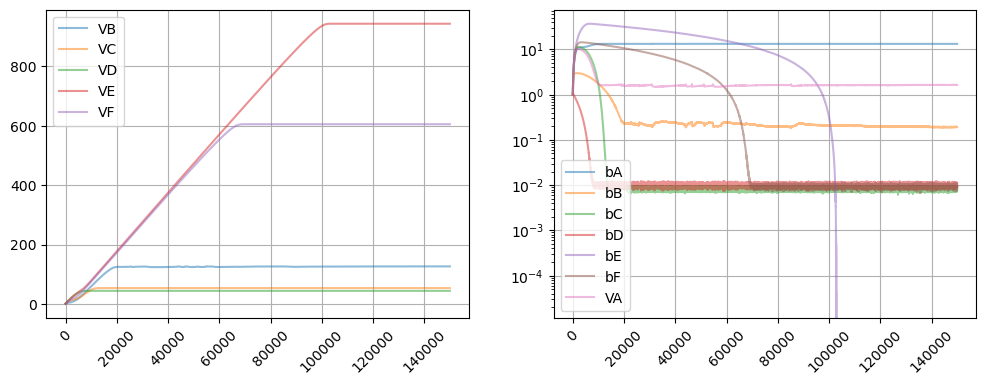

In [20]:
param_name = ["bA", "bB", "bC", "bD", "bE", "bF", "VA", "VB", "VC", "VD", "VE", "VF"]
plt.figure(figsize=(12,4));plt.subplot(121)
for i, n in enumerate(param_name):
    if params_est[-1,i] > 20:
        plt.plot(np.r_[params_est[:,i]], label=n, alpha=.5)
        
plt.legend();plt.xticks(rotation=45);plt.grid()
plt.subplot(122)
for i, n in enumerate(param_name):
    if params_est[-1,i] <= 20:
        plt.plot(np.r_[params_est[:,i]], label=n, alpha=.5)
        
plt.legend();plt.xticks(rotation=45);plt.grid();plt.yscale('log');plt.show()

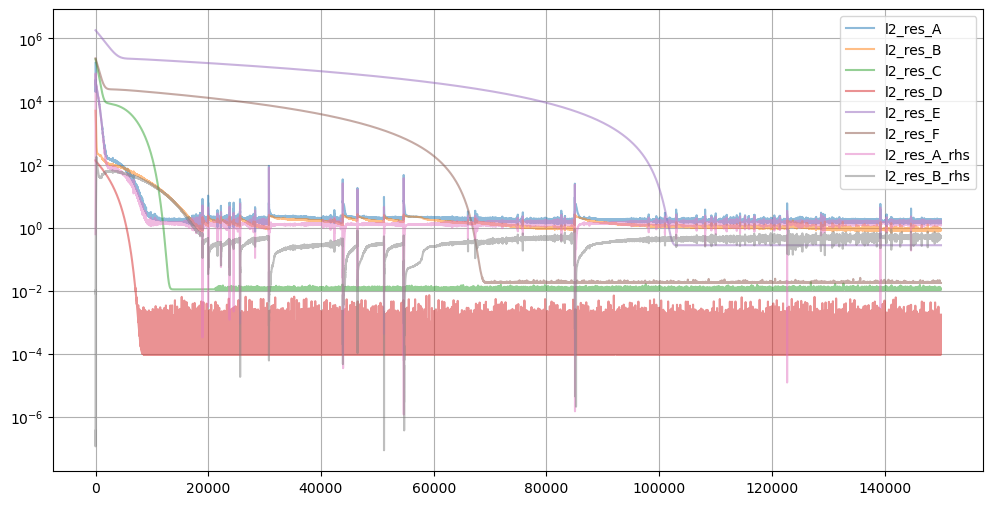

In [22]:
plt.figure(figsize=(12,6))
for i, n in enumerate(names):
    plt.plot(np.r_[losses1[:,i]], label=n, alpha=.5)
        
plt.legend();plt.grid();plt.yscale('log');plt.show()

In [51]:
@tf.function
def grads(pinn, H):
    def flatten(arr):
        return tf.reshape(arr, (arr.shape[0]*arr.shape[1]*arr.shape[2], arr.shape[3]))
    
    with tf.GradientTape(persistent=True) as tape:
        # remove the boundaries
        H = H[:, :, :, :]
        H = flatten(H)
        tape.watch(H)
        
        outputs = pinn.net(H)
        Ag = tf.squeeze(outputs[:, 0])
        Bg = tf.squeeze(outputs[:, 1])
        Cg = tf.squeeze(outputs[:, 2])
        Dg = tf.squeeze(outputs[:, 3])
        Eg = tf.squeeze(outputs[:, 4])
        Fg = tf.squeeze(outputs[:, 5])

        grad_A = tape.gradient(Ag, H)
        A_x = grad_A[:, 0]
        A_y = grad_A[:, 1]
        A_t = grad_A[:, 2]

        grad_B = tape.gradient(Bg, H)
        B_x = grad_B[:, 0]
        B_y = grad_B[:, 1]
        B_t = grad_B[:, 2]


        grad_A_x = tape.gradient(A_x, H)
        A_xx = grad_A_x[:, 0]
        grad_A_y = tape.gradient(A_y, H)
        A_yy = grad_A_y[:, 1]
        grad_B_x = tape.gradient(B_x, H)
        B_xx = grad_B_x[:, 0]
        grad_B_y = tape.gradient(B_y, H)
        B_yy = grad_B_y[:, 1]
        
        
    return (tf.squeeze(Ag), tf.squeeze(A_xx), tf.squeeze(A_yy), tf.squeeze(A_t),
            tf.squeeze(Bg), tf.squeeze(B_xx), tf.squeeze(B_yy), tf.squeeze(B_t),
            tf.squeeze(Cg), 
            tf.squeeze(Dg), 
            tf.squeeze(Eg), 
            tf.squeeze(Fg))                               
#     return (tf.squeeze(Ag), tf.squeeze(A_xx), tf.squeeze(A_yy), tf.squeeze(A_t),
#             tf.squeeze(Bg), tf.squeeze(B_xx), tf.squeeze(B_yy), tf.squeeze(B_t),
#             tf.squeeze(Cg), tf.squeeze(C_t),
#             tf.squeeze(Dg), tf.squeeze(D_t),
#             tf.squeeze(Eg), tf.squeeze(E_t),
#             tf.squeeze(Fg), tf.squeeze(F_t))

def to(arr):
    return arr.numpy().reshape(block_x, block_y)

def plot_state(pinn):
        (A, A_xx, A_yy, A_t,
         B, B_xx, B_yy, B_t,
         C,  D,  E,  F, 
        ) = grads(pinn, H)
        
        A_der = DA*( to(A_xx) + to(A_yy))
        B_der = DB*( to(B_xx) + to(B_yy))

        actual_A_der = DA*( c_xx[0,x_slice, y_slice  , -1] + c_yy[0,x_slice, y_slice  , -1])# - to(u_t2)[-1, ...]
        actual_B_der = DB*( c_xx[1,x_slice, y_slice  , -1] + c_yy[1,x_slice, y_slice  , -1])# - to(v_t2)[-1, ...]
        # X and Y are misoriented
        #A_der = A_der
        #B_der = B_der
        
        plot_n_im([to(A), c[0,:, : , -1], to(B), c[1,:, :  , -1]], 
          ["A", "Actual A", "B", "Actual B"],          
          figsize=(12, 3)); plt.tight_layout()

        A = c[0,:, : , -1]
        B = c[1,:, : , -1]

        
        
        plot_n_im([to(A_xx), c_xx[0,x_slice, y_slice , -1], to(A_yy), c_yy[0,x_slice, y_slice  , -1]], 
          ["A_xx", "Actual A_xx", "A_yy", "Actual A_yy"],          
          figsize=(12, 3)); plt.tight_layout()

        plot_n_im([to(B_xx), c_xx[1,x_slice, y_slice  , -1], to(B_yy), c_yy[1,x_slice, y_slice  , -1]],
                  ["B_xx", "Actual B_xx", "B_yy", "Actual B_yy"],          
                  figsize=(12, 3)); plt.tight_layout()
        plot_n_im([to(A_t),  c_t[0,x_slice, y_slice , -1],  to(B_t),  c_t[1,x_slice, y_slice , -1]],
                   ["A_t", "Actual A_t", "B_t", "Actual B_t"],          
                   figsize=(12, 3)); plt.tight_layout()
#         plot_n_im([c_t[0,x_slice, y_slice , -1],   c_t[1,x_slice, y_slice, -1]],
#                    ["Actual A_t",  "Actual B_t"],          
#                    figsize=(12, 3)); plt.tight_layout()
        plot_n_im([A_der,  actual_A_der],
                  ["RHS A", "Actual RHS A"],          
                  figsize=(12, 3)); plt.tight_layout()
        plot_n_im([B_der,  actual_B_der],
                  ["RHS B", "Actual RHS B"],          
                  figsize=(12, 3)); plt.tight_layout()
        plt.show()

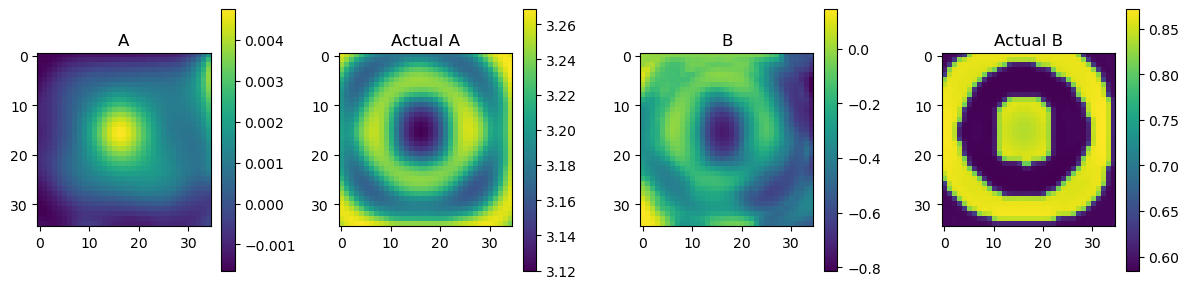

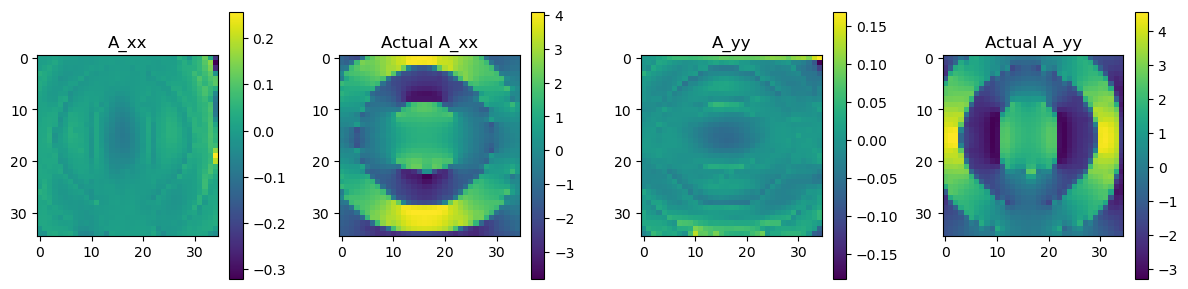

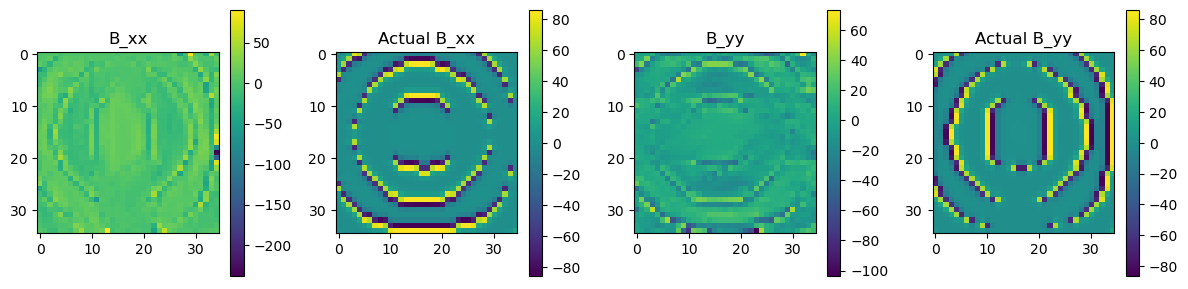

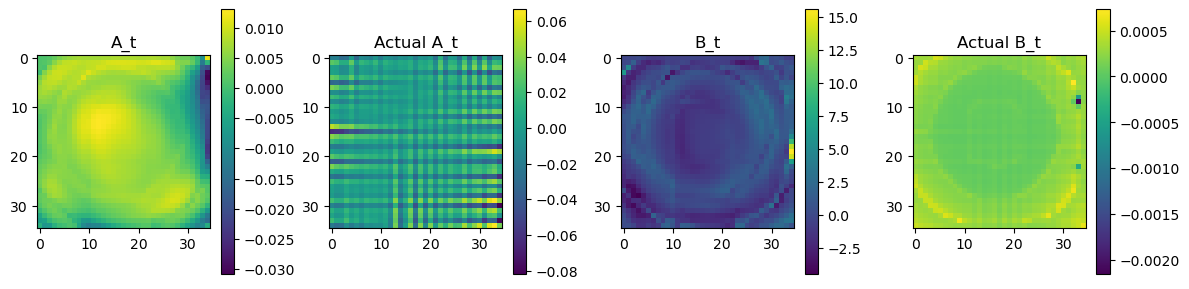

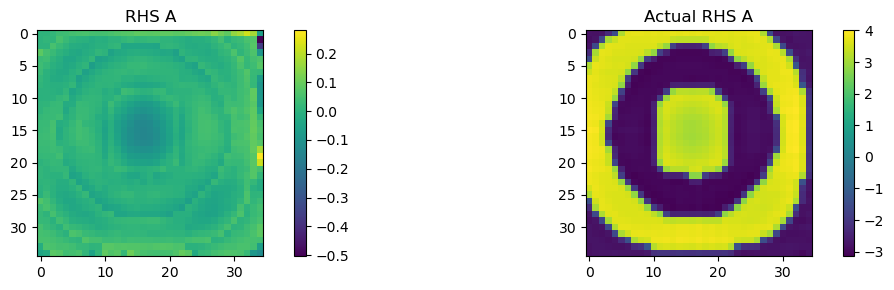

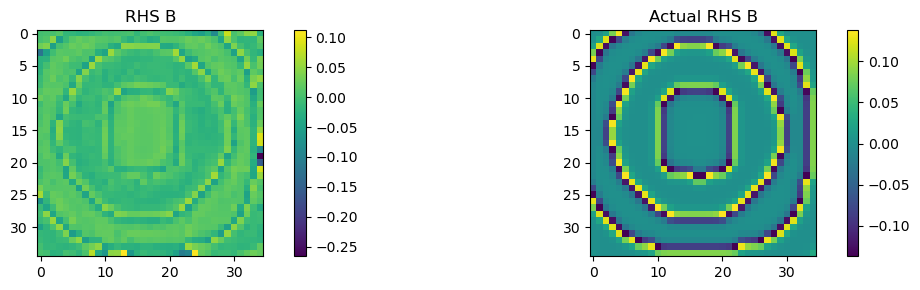

In [52]:
plot_state(pinn1)

In [44]:
(A, A_xx, A_yy, A_t,
         B, B_xx, B_yy, B_t,
         C,  D,  E,  F, 
        ) = grads(pinn1, H)

In [46]:
u_t_act = c_t[0,x_slice, y_slice , -1]
v_t_act = c_t[1,x_slice, y_slice , -1]
print(np.sum(u_t_act**2))
print(np.sum(v_t_act**2))
#print(np.sum(ders_t[0, :]**2))
#print(np.sum(ders_t[1, :]**2))

0.49224496907994086
6.61899213916773e-05


In [47]:
A_der = DA*( to(A_xx) + to(A_yy))
B_der = DB*( to(B_xx) + to(B_yy))

actual_A_der = DA*( c_xx[0,x_slice, y_slice  , -1] + c_yy[0,x_slice, y_slice  , -1])# - to(u_t2)[-1, ...]
actual_B_der = DB*( c_xx[1,x_slice, y_slice  , -1] + c_yy[1,x_slice, y_slice  , -1])# - to(v_t2)[-1, ...]

In [48]:
print(np.sum((A_der-actual_A_der)**2))
print(np.sqrt(np.mean((A_der-actual_A_der)**2)))
print(np.mean(np.abs(A_der-actual_A_der)/np.abs(actual_A_der)))
print(np.sum((B_der-actual_B_der)**2))
print(np.sqrt(np.mean((B_der-actual_B_der)**2)))
print(np.mean(np.abs(B_der-actual_B_der)/np.abs(actual_B_der)))

12227.016124856136
3.1593096798104146
1.0006027640997142
2.8518179967241473
0.04824950456951227
80.41426697586955
